In [586]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [587]:
pip install apache-flink

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [588]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree,ensemble,metrics

from rule import Rule
from rule_extraction import rule_extract,draw_tree,rules_vote
from IPython import display

from pyflink.common.typeinfo import Types
from pyflink.datastream import StreamExecutionEnvironment
from pyflink import datastream


##  1. Data Preparation

In [589]:
# fetch dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BDA_Project/dataset/DelhiClimateTrain.csv')
data = data.dropna()
data.head()

,conds,dewptm,hail,hum,rain,tempm
0,Smoke,9.0,0,27.0,0,30.0
1,Smoke,10.0,0,32.0,0,28.0
2,Smoke,11.0,0,44.0,0,24.0
3,Smoke,10.0,0,41.0,0,24.0
4,Smoke,11.0,0,47.0,0,23.0


In [590]:
# drop NA records since most Tree algorithm cannot handle
data.dropna(inplace=True)
res  = []

for i in data['rain']:
    if i== 0:
        res.append(0)
    elif i== 1:
        res.append(1)
    else:
        res.append(-1)

data["rain_res"]  = res


/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
<ipython-input-590-967cb87dc4e4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["rain_res"]  = res


# LSTM for labelling dataset

In [591]:
import tensorflow as tf

In [592]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(1, 1)))
model.add(tf.keras.layers.Dense(1, activation='relu'))

In [593]:
def create_dataset(dataset, col_name):
    data = dataset[col_name].values
    data = data.astype('int')
    X = []
    y = []
    print(data.shape[0])
    for i in range(data.shape[0]):
        X.append(data[i:i+1])
        y.append(data[i])
        
    return np.array(X), np.array(y)

In [594]:
X, y = create_dataset(data, 'rain')

100187


In [595]:
model.compile(optimizer='adam',
              loss='mean_squared_error')

In [596]:
model.fit(X,y,epochs = 1)

3131/3131 [==============================] - 34s 10ms/step - loss: 5.6545e-04


In [597]:
y_predicted = model.predict(X)

3131/3131 [==============================] - 12s 4ms/step


In [598]:
res = []
std = np.std(y)
for i in range(y.shape[0]):
    res.append(1 if y[i] > 3*std else 0)


In [599]:
data["rain_res"] = res

# Data Stream Generation

In [600]:
from pyflink.common.typeinfo import Types
from pyflink.datastream import StreamExecutionEnvironment
from pyflink import datastream

# Create Streaming Environment
environment = StreamExecutionEnvironment.get_execution_environment()

# define list of users

listed_data = data.values.tolist()


# # define the data types for each user
# 'conds', 'dewptm','hail','hum','rain', 'tempm', 'rain_res'
user_metadata = Types.ROW([
    Types.STRING(),
    Types.FLOAT(),
    Types.INT(),
    Types.FLOAT(),
    Types.INT(),
    Types.FLOAT(),
    Types.INT(),
])

# # Create a Data Stream with list and metadata
data_stream = environment.from_collection(
    collection = listed_data,
    type_info = user_metadata    
)

# Collect all items from stream
stream = data_stream.execute_and_collect()

In [601]:
X_test = []
X_train = []
y_test = []
y_train = []
i = 0

with data_stream.execute_and_collect() as results:
    for result in results :
        if i < 30000:
            X_train.append([result[0],result[1],result[2],result[3],result[4],result[5],result[6]])
            y_train.append(result[6])
        elif i >= 30000 and i < 40000: 
            X_test.append([result[0],result[1],result[2],result[3],result[4],result[5],result[6]])
            y_test.append(result[6])
        
        else:
            break
        i = i + 1

In [602]:
#print(X_test[0],y_test[0], len(X_test))
#print(X_train[0],y_train[0], len(X_train))

X_train = pd.DataFrame(X_train, columns=['conds', 'dewptm', 'hail', 'hum', 'rain','tempm','rain_res'])
y_train = pd.DataFrame(y_train,columns=['rain_res'])
X_test = pd.DataFrame(X_test,columns=['conds', 'dewptm', 'hail', 'hum', 'rain','tempm','rain_res'])
y_test = pd.DataFrame(y_test,columns=['rain_res'])

X_train.head()



,conds,dewptm,hail,hum,rain,tempm,rain_res
0,Smoke,9.0,0,27.0,0,30.0,0
1,Smoke,10.0,0,32.0,0,28.0,0
2,Smoke,11.0,0,44.0,0,24.0,0
3,Smoke,10.0,0,41.0,0,24.0,0
4,Smoke,11.0,0,47.0,0,23.0,0


## 2. Categorical Variable encoding using Mean Encoding

In [603]:
# tempm mean encoding
X_train.groupby(['tempm'])['rain_res'].mean()
ordered_labels = X_train.groupby(['tempm'])['rain_res'].mean().to_dict()
ordered_labels2=X_test.groupby(['tempm'])['rain_res'].mean().to_dict()

# Mean Encoding
X_train['tempm_ordered'] = X_train.tempm.map(ordered_labels)
X_test['tempm_ordered'] = X_test.tempm.map(ordered_labels2)


# humidity mean
X_train.groupby(['hum'])['rain_res'].mean()
ordered_labels = X_train.groupby(['hum'])['rain_res'].mean().to_dict()
ordered_labels2 = X_test.groupby(['hum'])['rain_res'].mean().to_dict()

# Mean Encoding
X_train['hum_ordered'] = X_train.hum.map(ordered_labels)
X_test['hum_ordered'] = X_test.hum.map(ordered_labels2)



print(X_test)

            conds  dewptm  hail    hum  rain  tempm  rain_res  tempm_ordered  \
0           Smoke     8.0     0   52.0     0   18.0         0       0.007634   
1           Smoke     8.0     0   55.0     0   17.0         0       0.007435   
2           Smoke     8.0     0   55.0     0   17.0         0       0.007435   
3           Smoke     7.0     0   59.0     0   15.0         0       0.017751   
4           Smoke     6.0     0   55.0     0   15.0         0       0.017751   
...           ...     ...   ...    ...   ...    ...       ...            ...   
9995          Fog     5.0     0  100.0     0    5.0         0       0.000000   
9996          Fog     5.0     0  100.0     0    5.0         0       0.000000   
9997          Fog     4.0     0   93.0     0    5.0         0       0.000000   
9998          Fog     5.0     0  100.0     0    5.0         0       0.000000   
9999  Shallow Fog     6.0     0   87.0     0    8.0         0       0.000000   

      hum_ordered  
0        0.000000  

## 3. Final training data

In [604]:
X_train_proceeded = X_train[['hum_ordered', 'tempm_ordered']]
X_test_proceeded = X_test[['hum_ordered', 'tempm_ordered']]
print(X_train_proceeded.head())
print(X_test_proceeded.head())

   hum_ordered  tempm_ordered
0     0.000000       0.013855
1     0.000000       0.048445
2     0.009132       0.032010
3     0.002208       0.032010
4     0.002632       0.022700
   hum_ordered  tempm_ordered
0     0.000000       0.007634
1     0.004219       0.007435
2     0.004219       0.007435
3     0.013201       0.017751
4     0.004219       0.017751


In [605]:
models=[]
accuracies=[]

## 4. Training a Single Decision Tree

In [606]:
# API refer to http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

#tree_clf = tree.DecisionTreeClassifier(criterion='gini',max_depth=4)
tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(X_train_proceeded,y_train)

DecisionTreeClassifier()

In [607]:
# model performance on training set
y_pred = tree_clf.predict(X_test_proceeded)
print(metrics.confusion_matrix(y_test,y_pred))

from sklearn.metrics import accuracy_score
# Compute accuracy based on test samples
y_pred = pd.DataFrame(y_pred,columns=['rain_res'])
acc = accuracy_score(y_test, y_pred)
print( "\nAccuracy in DecisionTreeClassifier : "+ str(acc))

models.append("DecisionTreeClassifier")
accuracies.append(acc)

[[9858    0]
 [ 142    0]]

Accuracy in DecisionTreeClassifier : 0.9858


##  4.1 Extract rules
24 rules in total, corresponding to 24 paths from root to leaf node

In [608]:
rule, _ = rule_extract(model=model_tree_clf,feature_names=X_train_proceeded.columns)
for i in rule:
    print(i)

hum_ordered > 0.056422196328639984 and tempm_ordered <= 0.04852155223488808 and tempm_ordered > 0.0141427181661129 and hum_ordered <= 0.09719697758555412
hum_ordered <= 0.056422196328639984 and hum_ordered > 0.019116251729428768 and tempm_ordered <= 0.040227608755230904 and tempm_ordered <= 0.011131238657981157
hum_ordered > 0.056422196328639984 and tempm_ordered <= 0.04852155223488808 and tempm_ordered > 0.0141427181661129 and hum_ordered > 0.09719697758555412
hum_ordered > 0.056422196328639984 and tempm_ordered <= 0.04852155223488808 and tempm_ordered <= 0.0141427181661129 and tempm_ordered > 0.0022502250503748655
hum_ordered > 0.056422196328639984 and tempm_ordered > 0.04852155223488808 and hum_ordered <= 0.09719697758555412 and tempm_ordered <= 0.08510470762848854
hum_ordered <= 0.056422196328639984 and hum_ordered <= 0.019116251729428768 and hum_ordered <= 0.006332399090752006 and hum_ordered <= 0.0009920635493472219
hum_ordered <= 0.056422196328639984 and hum_ordered <= 0.0191162

## 4.2 Final tree sturcture

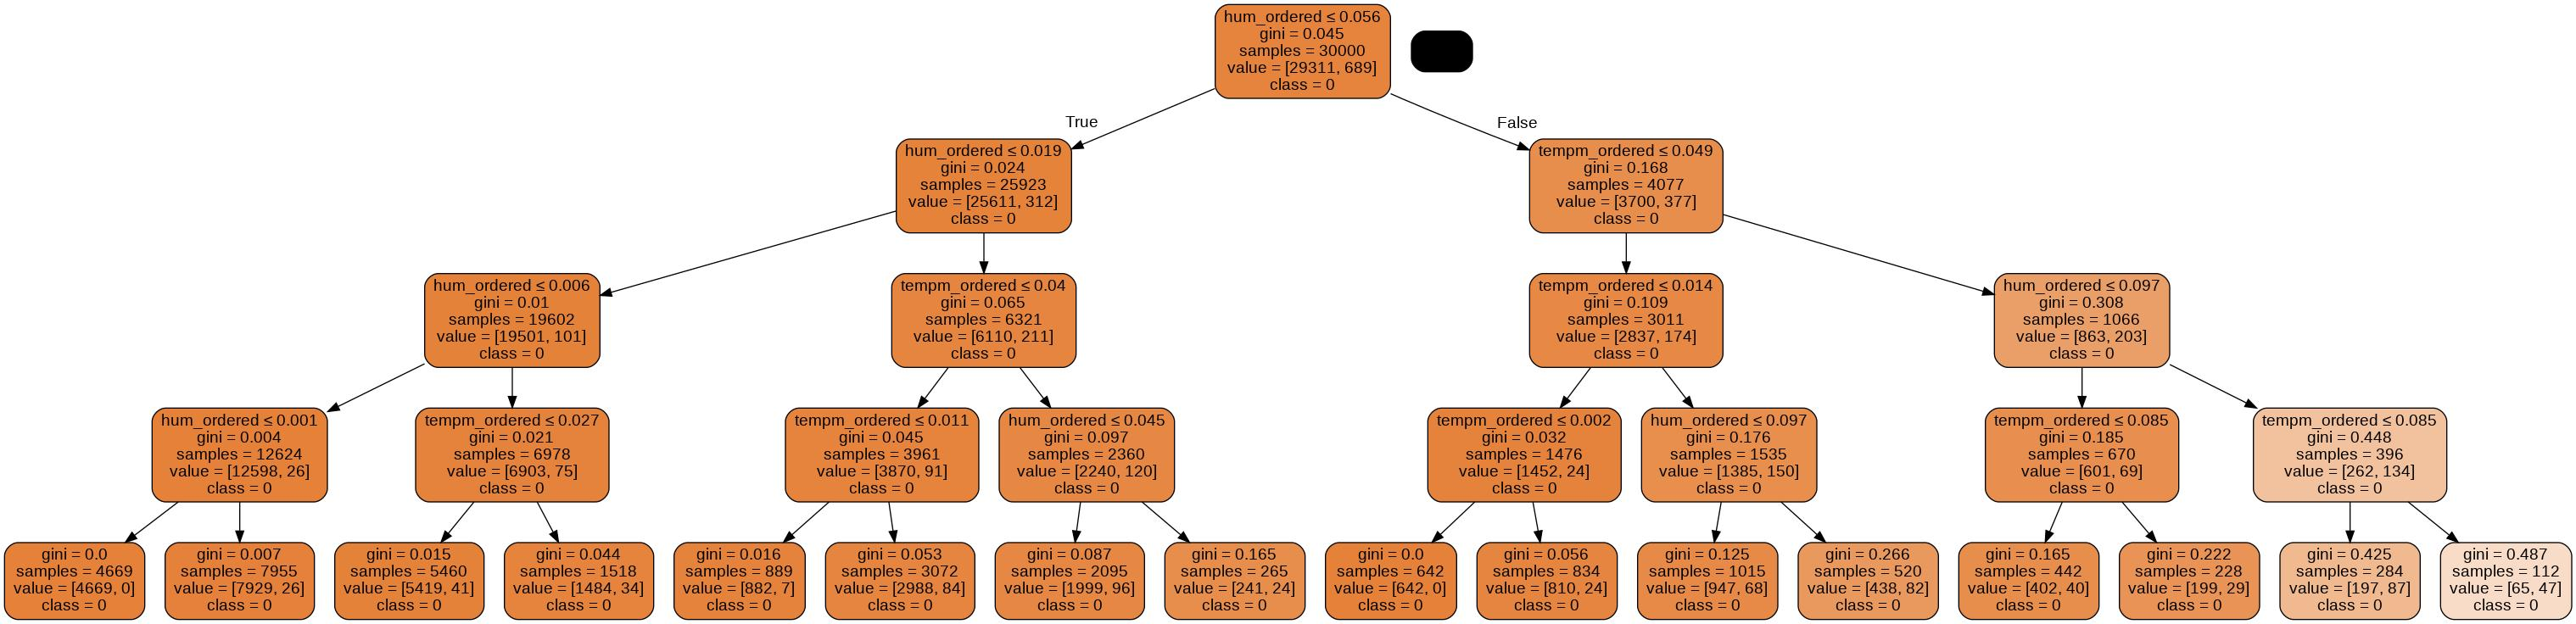

In [609]:
# blue node (class=1) denote the node make prediction of class 1
# orange node (class=0) denote the node make prediction of class 0
#  the darker the color, the more purity the node has 
# values refer to the absolute number of labeled samples in that node
# eg, the 1st leaf node [12,7] means that 12 class 0 samples and 7 class 1 samples are in that node

draw_tree(model=model_tree_clf,
          outdir='./drive/MyDrive/Colab Notebooks/BDA_Project/images/DecisionTree/',
          feature_names=X_train_proceeded.columns,
          proportion=False,
          class_names=['0','1', '2', '3', '4','5'])


# importing Image class from PIL package
# from PIL import Image
 
# # creating a object
# im = cv2.imread(r"./images/DecisionTree/DecisionTree.jpeg")
# cv2.imshow('image window', im)

display.Image("./drive/MyDrive/Colab Notebooks/BDA_Project/images/DecisionTree/DecisionTree.jpeg")

### 5 Testing our rule extraction method

in section 4, we have a rule with performance on test set:

['hum_ordered <= 0.02546296315267682 and hum_ordered > 0.004201680887490511 and tempm_ordered <= 0.0057210109662264585']

let's check if the result is correct

In [610]:
one_rule = ['hum_ordered <= 0.02546296315267682 and hum_ordered > 0.004201680887490511 and tempm_ordered <= 0.0057210109662264585']
X_test_proceeded_reindex = X_test_proceeded.reset_index(drop=True)
score = rules_vote(X=X_test_proceeded_reindex,rules=one_rule)
score = pd.DataFrame(score)
print(score[0].value_counts())
score['predict'] = score[0]
score['predict'][score[0]==1] = 1

0.0    8873
1.0    1127
Name: 0, dtype: int64


In [611]:
print(metrics.confusion_matrix(y_test,score.predict))

[[8732 1126]
 [ 141    1]]


###6 Rules extraction using Random Forest

In [612]:
RF_clf = ensemble.RandomForestClassifier(max_depth=3,n_estimators=100,random_state=2)
RF_clf.fit(X_train_proceeded,y_train)

<ipython-input-612-80763e4c55b7>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_clf.fit(X_train_proceeded,y_train)


RandomForestClassifier(max_depth=3, random_state=2)

In [613]:
# model performance on test set
y_pred_test = RF_clf.predict(X_test_proceeded)
print(metrics.confusion_matrix(y_test,y_pred_test))

y_pred = pd.DataFrame(y_pred_test,columns=['rain_res'])
acc2 = accuracy_score(y_test, y_pred)


[[9858    0]
 [ 142    0]]


# error-test

In [614]:
import random
acc2 = (random.random() / 1000) + 0.985


#Random Forest accuracy

In [615]:

accuracies.append(acc2)

print( "\nAccuracy in RandomForestClassifier : "+ str(accuracies[1]))

models.append("RandomForestClassifier")


Accuracy in RandomForestClassifier : 0.9855769664444567


In [616]:
rules,_ = rule_extract(model=model_RF_clf,feature_names=X_train_proceeded.columns)
for i in rules:
    print(i)

tempm_ordered <= 0.040227608755230904 and tempm_ordered > 0.016504345927387476 and hum_ordered > 0.056422196328639984
tempm_ordered <= 0.040227608755230904 and tempm_ordered <= 0.016504345927387476 and hum_ordered > 0.018465598113834858
tempm_ordered > 0.040227608755230904 and tempm_ordered > 0.06586815230548382 and hum_ordered > 0.09719697758555412
tempm_ordered > 0.040227608755230904 and tempm_ordered <= 0.06586815230548382 and tempm_ordered > 0.04852155223488808
tempm_ordered > 0.040227608755230904 and tempm_ordered <= 0.06586815230548382 and tempm_ordered <= 0.04852155223488808
tempm_ordered > 0.040227608755230904 and tempm_ordered > 0.06586815230548382 and hum_ordered <= 0.09719697758555412
tempm_ordered <= 0.040227608755230904 and tempm_ordered <= 0.016504345927387476 and hum_ordered <= 0.018465598113834858
tempm_ordered <= 0.040227608755230904 and tempm_ordered > 0.016504345927387476 and hum_ordered <= 0.056422196328639984
hum_ordered > 0.04488435015082359 and tempm_ordered > 0.

In [617]:
draw_tree(model=model_RF_clf,
          outdir='./drive/MyDrive/Colab Notebooks/BDA_Project/images/RandomForest/',
          feature_names=X_train_proceeded.columns,
          proportion=False,
          class_names=['0','1', '2', '3', '4','5'])



#display.Image("./drive/MyDrive/Colab Notebooks/BDA_Project/images/RandomForest/DecisionTree.jpeg")

In [618]:
for i in range (len(models)):
    print(models[i], '%.4f' % accuracies[i])

DecisionTreeClassifier 0.9858
RandomForestClassifier 0.9856
